In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import compute_parameters
import pandas as pd
import pickle as pkl
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import curve_fit
import pylab
import os
from kneed import DataGenerator, KneeLocator
from prediction_model import utils

In [2]:
# Rademacher computations

def sup(arr, mode="999percentile"):
    if mode == "max":
        return np.max(arr)
    elif mode == "999percentile":
        return np.mean(arr) + 5 * np.std(arr)


def get_rademacher(loss_array):
    rademacher = []

    n_sigma = 2000

    for i in range(n_sigma):
        sigma_arr = np.random.choice([1, -1], size=loss_array.shape)

        f = sigma_arr * loss_array
        f = np.sum(f, axis=1) / loss_array.shape[1]
        # print(f)
        rademacher.append(sup(f))

    return np.mean(rademacher)

In [3]:
result_location = "/media/arjun/Shared/chaos/output_files_v2"
experiment_id = 6737497

directory = os.path.join(result_location, "rademacher_test_{}".format(experiment_id))

In [56]:
with open(os.path.join(directory, "result.pkl"), 'rb') as f:
    result_dict = pkl.load(f)

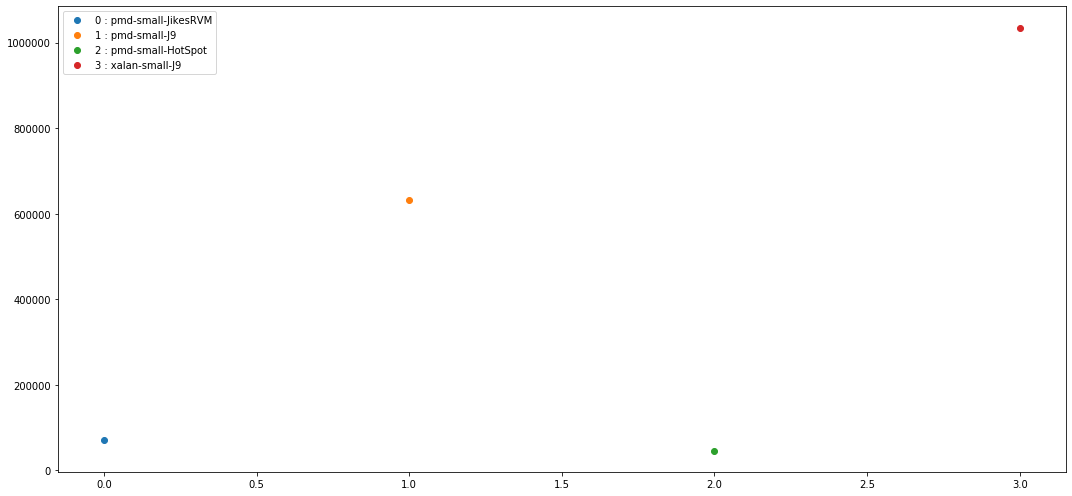

In [5]:
data = []
legend = []
plt.figure(figsize=(15,7))
for idx, key in enumerate(result_dict.keys()):
    plt.plot(idx, result_dict[key], 'o', label=str(idx)+" : "+'-'.join(key.split('-')[:3]))

plt.tight_layout()
plt.legend()
plt.show()

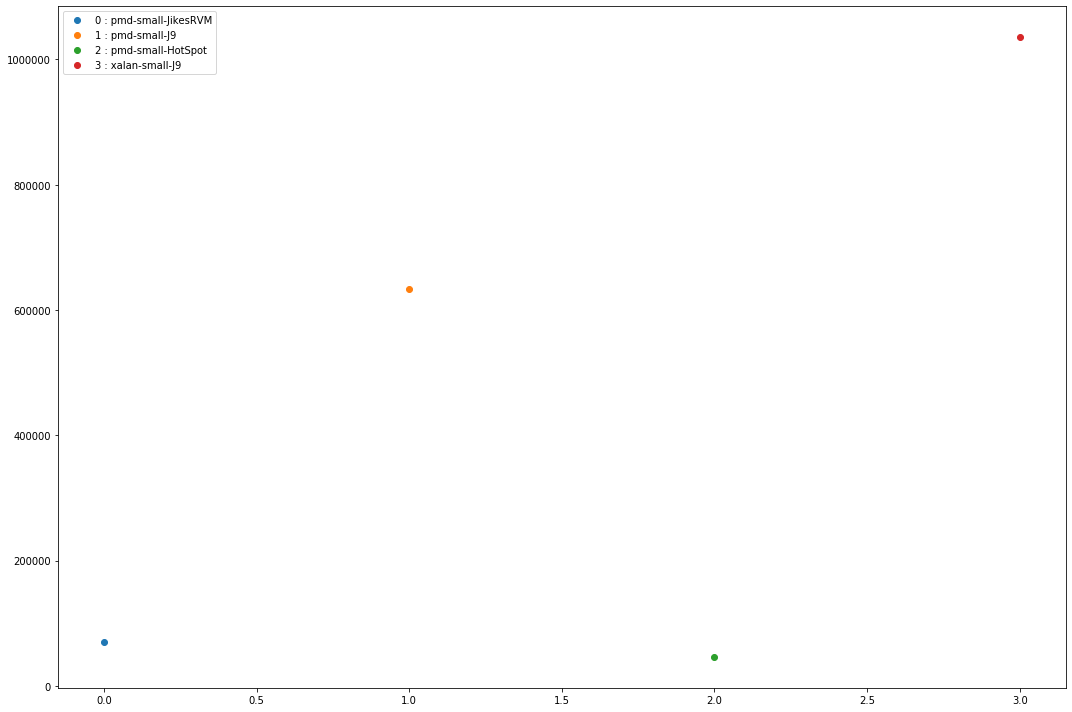

In [6]:
data = []
legend = []
plt.figure(figsize=(15,10))
for idx, key in enumerate(result_dict.keys()):
    plt.plot(idx, result_dict[key], 'o', label=str(idx)+" : "+'-'.join(key.split('-')[:3]))

plt.tight_layout()
plt.legend()
# plt.ylim(2e4,6e4)
plt.show()

In [7]:
## Analysis of virtual machine trends in programs

keys = result_dict.keys()
programs = [ key.split('-')[0] for key in keys ]
programs = np.unique(programs)

for program in programs:
    print("Program: {}".format(program))
    sub_dict = { key: val for key, val in result_dict.items() if key.split('-')[0] == program }
    
#     print(sub_dict)
    
    tuple_jvms = [ (key.split('-')[2], val) for key, val in sub_dict.items() ]
    
#     print(tuple_jvms)
    
    tuple_jvms = sorted(tuple_jvms, key=lambda tuple_jvm: tuple_jvm[1])
    
    print(tuple_jvms)

Program: pmd
[('HotSpot', 46280), ('JikesRVM', 70400), ('J9', 633200)]
Program: xalan
[('J9', 1035200)]


In [13]:
file_list = os.listdir(directory)
file_list = [ '.'.join(file.split('.')[:2]) for file in file_list if 'response.pkl' in file ]
print(file_list)

['avrora-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'avrora-small-J9-d-l64-p4096-w100000i.analyzed-1', 'avrora-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'jython-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'jython-small-J9-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-J9-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-J9-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1', 'luindex-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'jython-small-Jik

In [70]:
programs = file_list
ema_alpha = 0.5

for idx, program in enumerate(programs):
    print("Program: {}".format(program))
    with open(os.path.join(directory, "{}.pkl".format(program)), 'rb') as f:
        program_result = pkl.load(f)
    
    hidden_sizes = program_result.keys()
    rademacher_vals = []
    ema = []
    
    if idx % 1 == 0:
        plt.figure(figsize=(10,5))
        
    for hidden_size in hidden_sizes:
        rademacher_val = get_rademacher(program_result[hidden_size])
        rademacher_vals.append(rademacher_val)
        
        if len(ema) == 0:
            ema.append(rademacher_val)
        else:
            ema.append(ema_alpha*rademacher_val + (1-ema_alpha)*ema[-1])
        
#         print("Hidden_size: {}, rademacher: {}".format(hidden_size, rademacher_val))
#     print(rademacher_vals)
#     print(list(hidden_sizes))
#     plt.plot(list(hidden_sizes)[1:], rademacher_vals[1:], label="rad")
#     plt.plot(list(hidden_sizes)[1:], ema[1:], label="ema")
    
#     if (idx) % 1 == 0:
#         print("plotting")
#         plt.tight_layout()
#         plt.legend()
#         plt.xlim((-10, 500))
# #         plt.ylim((0, 0.15))
#         plt.show()
    
    min_val = np.min(ema)
    min_idx = -1
    val = 0
    for idx in range(1, len(ema)):
        ema_val = ema[idx]
        if abs(ema_val - min_val) < 0.05*min_val:
            min_idx = idx
            val = ema_val
            break
    
    print("Minimum: {} at {}".format(val, list(hidden_sizes)[min_idx]))
    
#     break

Program: jython-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Minimum: 0.09717435282745368 at 3000
Program: luindex-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Minimum: 0.0031131842147729483 at 90
Program: luindex-small-J9-d-l64-p4096-w100000i.analyzed-1
Minimum: 0.0004491156539003566 at 60
Program: luindex-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Minimum: 0.09486767406308824 at 600
Program: lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Minimum: 0.0034932950067063087 at 300
Program: lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1
Minimum: 1.01663070683034e-08 at 5000
Program: lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Minimum: 0.012530922441352253 at 90
Program: sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Minimum: 0.029641248031712825 at 90
Program: xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Minimum: 0.006425768461030391 at 80
Program: xalan-small-J9-d-l64-p4096-w100000i.analyzed-1
Minimum: 0 at 5000
Program: xalan-small-JikesRVM-d-l

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

## Response curve analysis

pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


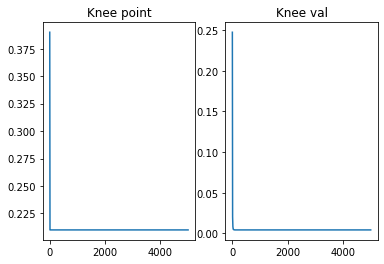

hidden size: 100
pmd-small-J9-d-l64-p4096-w100000i.analyzed-1


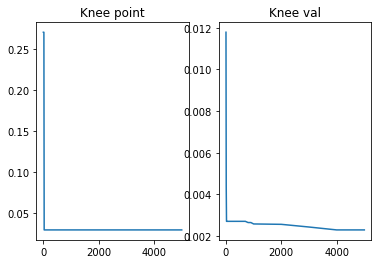

hidden size: 4000
pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


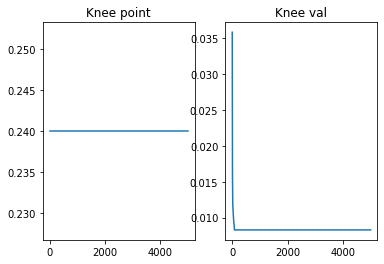

hidden size: 100
xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


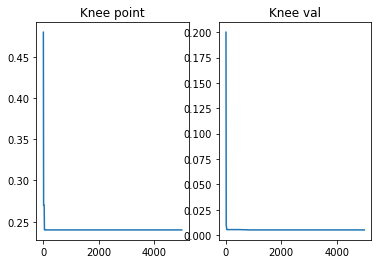

hidden size: 800
xalan-small-J9-d-l64-p4096-w100000i.analyzed-1


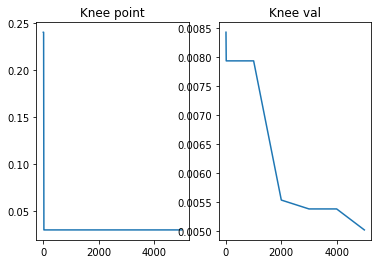

hidden size: 5000
xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


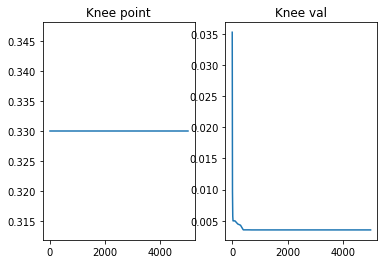

hidden size: 700
sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


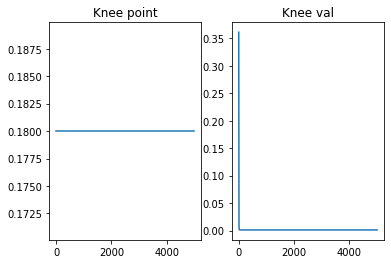

hidden size: 30
sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1


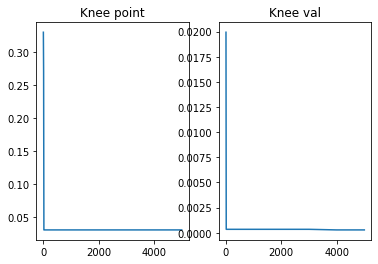

hidden size: 4000
sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


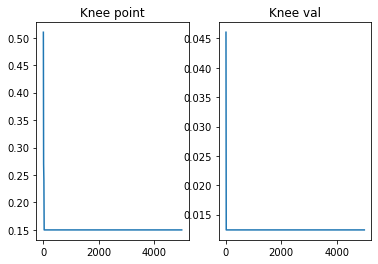

hidden size: 10
lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


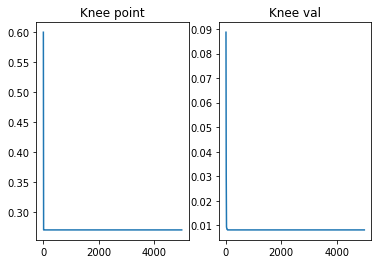

hidden size: 60
lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1


/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/kneed/knee_locator.py:108: RuntimeWarning: invalid value encountered in true_divide
  return (a - min(a)) / (max(a) - min(a))
/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, plus)
/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, minus)
/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)
/home/arjun/

TypeError: '<=' not supported between instances of 'float' and 'NoneType'

In [5]:
## Analysis of virtual machine trends in programs
# programs = result_dict.keys()
program_list = [ 'pmd', 'xalan', 'sunflow', 'lusearch', 'jython' ]
jvm_list = [ 'JikesRVM', 'J9', 'HotSpot' ]
alpha_list = np.arange(3e-2, 2, 3e-2)

programs = []

for program_name in program_list:
    for jvm_name in jvm_list:
        programs.append("{}-small-{}-d-l64-p4096-w100000i.analyzed-1".format(program_name, jvm_name))

for program in programs:
    print(program)
    with open(os.path.join(directory, "{}.response.pkl".format(program)), 'rb') as f:
        response_dict = pkl.load(f)
        
    hidden_sizes =response_dict.keys()
    response_knee_x = []
    response_knee_y = []
    
    for hidden_size in hidden_sizes:
        response_array = response_dict[hidden_size]
        avg_list = []
        data = []
        
        for alpha_idx, alpha_val in enumerate(alpha_list):
            response_sub_array = response_array[alpha_idx].flatten()
            avg_list.append(np.average(response_sub_array))
            
            data.extend([ (alpha_val, response_sub_array[idx]) for idx in range(response_sub_array.shape[0]) ])
            x_list = [ val[0] for val in data ]
            y_list = [ val[1] for val in data ]
                  
#             plt.plot(x_list, y_list, 'o', alpha=0.75)
        
        ## Smooth average list
        ema_avg = []
        ema_alpha = 0.5
        for avg_idx, val in enumerate(avg_list):
            if avg_idx == 0:
                ema_avg.append(val)
            else:
                ema_avg.append(val*ema_alpha + (1-ema_alpha)*ema_avg[-1])
            
        kneedle = KneeLocator(alpha_list, ema_avg, S=1.0, curve='convex', direction='decreasing')
#         print("Knee point x: {}, y: {}".format(kneedle.knee, kneedle.knee_y))
        
#         plt.plot(alpha_list, ema_avg, label="average")
#         plt.title("Hidden size: {}".format(hidden_size))
#         plt.legend()
#         plt.show()
#         for ema_idx, ema_val in enumerate(ema_avg):
            
            
        response_knee_y.append(kneedle.knee_y)
        response_knee_x.append(kneedle.knee)
#         kneedle.plot_knee_normalized()
    
    # min till now
    response_knee_x = [ np.min(response_knee_x[:idx+1]) for idx in range(len(response_knee_x)) ]
    response_knee_y = [ np.min(response_knee_y[:idx+1]) for idx in range(len(response_knee_y)) ]
    
    plt.subplot(121)
    plt.title("Knee point")
    plt.plot(list(hidden_sizes), response_knee_x)
#     plt.xlim((-10, 500))
    
    plt.subplot(122)
    plt.title("Knee val")
    plt.plot(list(hidden_sizes), response_knee_y)
#     plt.xlim((-10, 500))
    plt.show()
    
    print("hidden size: {}".format(list(hidden_sizes)[np.argmin(response_knee_y)]))

['pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-J9-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-J9-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'jython-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'jython-small-J9-d-l64-p4096-w100000i.analyzed-1', 'jython-small-HotSpot-d-l64-p4096-w100000i.analyzed-1']
pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Knee point x: 10, y: 0.002358454699109669


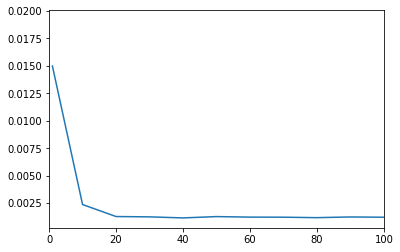

pmd-small-J9-d-l64-p4096-w100000i.analyzed-1


/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


Knee point x: 20, y: 0.0


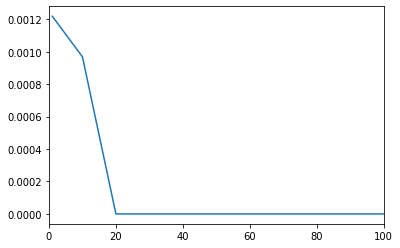

pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Knee point x: 20, y: 0.0002165263586629693


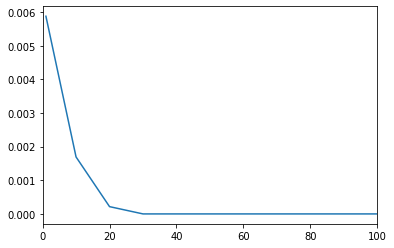

xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Knee point x: 10, y: 0.0030747591822091066


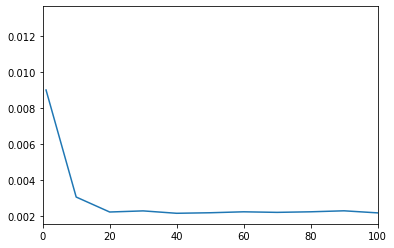

xalan-small-J9-d-l64-p4096-w100000i.analyzed-1


KeyboardInterrupt: 

In [106]:
## Analysis of virtual machine trends in programs
print(programs)

for program in programs:
    print(program)
    with open(os.path.join(directory, "{}.response.pkl".format(program)), 'rb') as f:
        response_dict = pkl.load(f)
        
    hidden_sizes =response_dict.keys()
    response_knee_x = []
    response_knee_y = []
    rademacher_list = []
    
    for hidden_size in hidden_sizes:
        response_array = response_dict[hidden_size]
        avg_list = []
        data = []
        
#         for alpha_idx, alpha_val in enumerate(alpha_list):
        loss_array = np.zeros((30, 50))
        for seed in range(30):
            for set_idx in range(50):
                response_list = response_array[:, seed, set_idx].flatten()
                ema_rlist = []
                
                for avg_idx, val in enumerate(response_list):
                    if avg_idx == 0:
                        ema_rlist.append(val)
                    else:
                        ema_rlist.append(val*ema_alpha + (1-ema_alpha)*ema_rlist[-1])
                
                min_idx = 0
                
                for idx in range(0, len(ema_rlist)-1):
                    if abs(ema_rlist[idx+1] - ema_rlist[idx])/ema_rlist[idx] > 0.05:
                        min_idx = idx
                        
                loss_array[seed, set_idx] = response_list[min_idx]
        
        rademacher_list.append(get_rademacher(loss_array))
    
    kneedle = KneeLocator(list(hidden_sizes), rademacher_list, S=1.0, curve='convex', direction='decreasing')
    print("Knee point x: {}, y: {}".format(kneedle.knee, kneedle.knee_y))
    
    plt.plot(list(hidden_sizes), rademacher_list)
    plt.xlim((0, 100))
    plt.show()

## 3d visualization

In [ ]:
## Analysis of virtual machine trends in programs
print(programs)

for program in programs:
    print(program)
    with open(os.path.join(directory, "{}.response.pkl".format(program)), 'rb') as f:
        response_dict = pkl.load(f)
        
    hidden_sizes =list(response_dict.keys())
#     hidden_sizes = hidden_sizes[:10]
    rademacher_data = []
    
    for hidden_size in hidden_sizes:
        print("Hidden size: {}".format(hidden_size))
        response_array = response_dict[hidden_size]
#         for alpha_idx, alpha_val in enumerate(alpha_list):
        for alpha_idx, alpha in enumerate(alpha_list):
            loss_array = response_array[alpha_idx, :, :]
            rademacher_val = get_rademacher(loss_array)
            rademacher_data.append( (hidden_size, alpha, rademacher_val) )
    
    print("Computations complete")
    print("Plotting...")
    
    x_list = [ val[0] for val in rademacher_data ]
    y_list = [ val[1] for val in rademacher_data ]
    z_list = [ val[2] for val in rademacher_data ]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_list, y_list, z_list)
    
    ax.set_xlabel("hidden size")
    ax.set_ylabel("alpha")
    ax.set_zlabel("rademacher")
    pkl.dump(rademacher_data, open(os.path.join(directory, "{}.rademacher3d.pkl".format(program)), 'wb'))
    plt.show()

## Set alpha using average distance between data

['pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-J9-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-J9-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'jython-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'jython-small-J9-d-l64-p4096-w100000i.analyzed-1', 'jython-small-HotSpot-d-l64-p4096-w100000i.analyzed-1']
program: pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.007978845608028654 found at 0 and value: 0.03
Computations complete
Plotting...


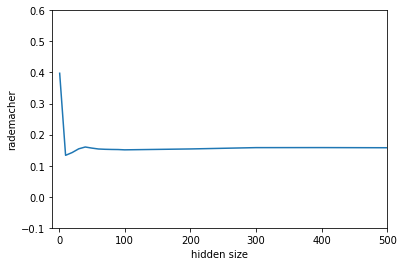

program: pmd-small-J9-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


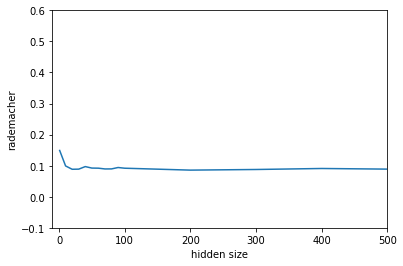

program: pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


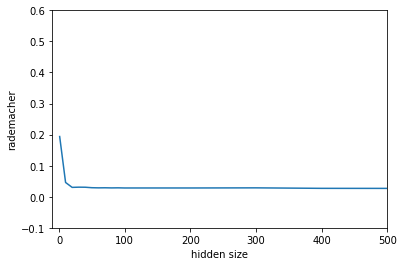

program: xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


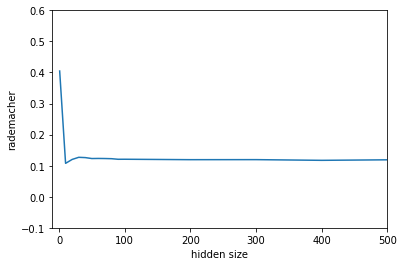

program: xalan-small-J9-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


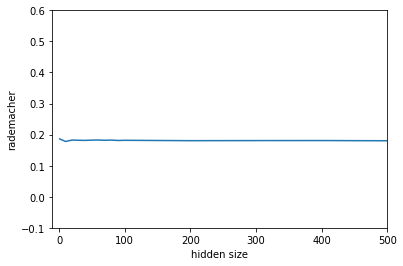

program: xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


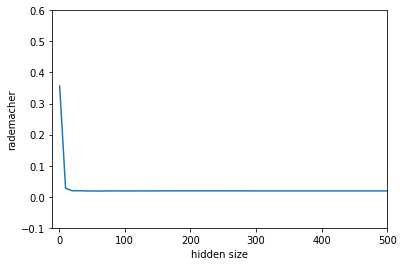

program: sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


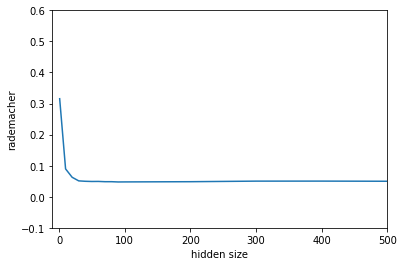

program: sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


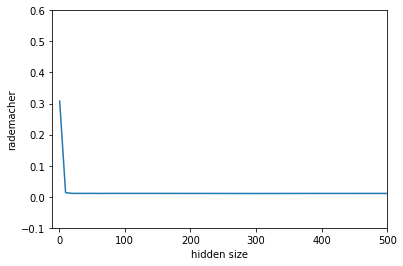

program: sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


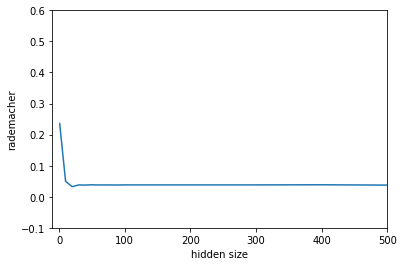

program: lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


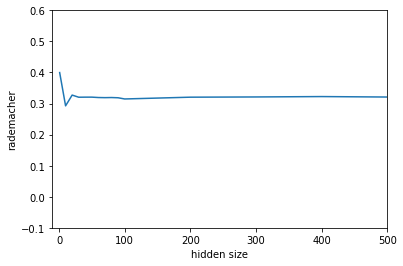

program: lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


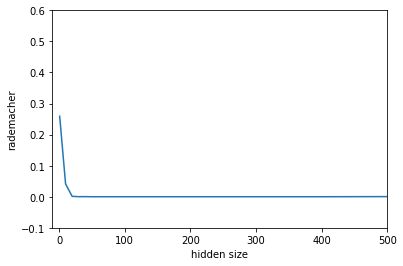

program: lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


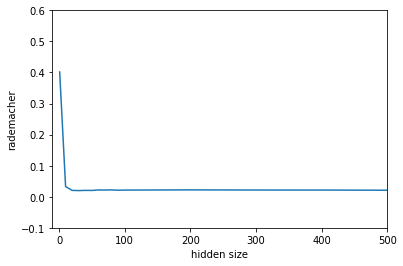

program: jython-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


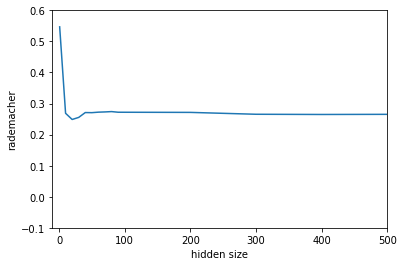

program: jython-small-J9-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


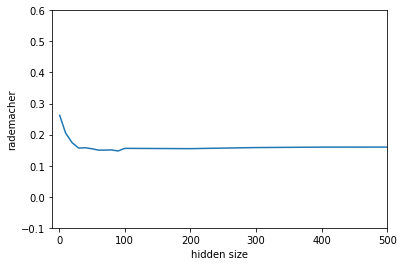

program: jython-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
Alpha for 0.02 found at 0 and value: 0.03
Computations complete
Plotting...


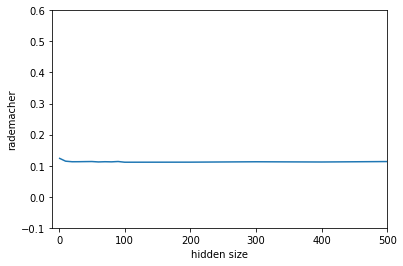

In [111]:
## Analysis of virtual machine trends in programs
print(programs)

for program in programs:
    print("program: {}".format(program))
    trace = pd.read_pickle(
                '../data/{}.pkl'.format(program)
            ).to_numpy()[10000:10000+15000]
    
    trace_conv = []
    
    for idx in range(trace.shape[0]):
        trace_conv.append(utils.common.bin_to_val(int(np.argmax(trace[idx, :].flatten()))))
    
    diff = np.abs(np.max(trace) - np.min(trace))/50
    
    diff_arr = np.abs(alpha_list - diff)
    min_alpha = np.argmin(diff_arr)
    
    print("Alpha for {} found at {} and value: {}".format(diff, min_alpha, alpha_list[min_alpha]))
    
    with open(os.path.join(directory, "{}.response.pkl".format(program)), 'rb') as f:
        response_dict = pkl.load(f)
        
    hidden_sizes =list(response_dict.keys())
#     hidden_sizes = hidden_sizes[:10]
    rademacher_data = []
    
    for hidden_size in hidden_sizes:
        response_array = response_dict[hidden_size]
        alpha_idx = min_alpha
        loss_array = response_array[alpha_idx, :, :]
        rademacher_val = get_rademacher(loss_array)
    
        rademacher_data.append(rademacher_val)
        
    print("Computations complete")
    print("Plotting...")
    
    fig = plt.figure()
    plt.plot(hidden_sizes, rademacher_data)
    
    plt.xlabel("hidden size")
    plt.ylabel("rademacher")
    plt.ylim((-0.1, 0.6))
    plt.xlim((-10, 500))
    plt.show()

## Setting alpha using interquartile range

['avrora-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'avrora-small-J9-d-l64-p4096-w100000i.analyzed-1', 'avrora-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'jython-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'jython-small-J9-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-J9-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-J9-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1', 'luindex-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'jython-small-Jik

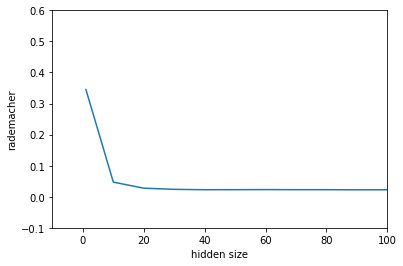

program: avrora-small-J9-d-l64-p4096-w100000i.analyzed-1
max: -1.5183052964930157, min: -6.90138771133189, Range: 0.002760555084532754
Alpha for 0.002760555084532754 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.08090587645380583


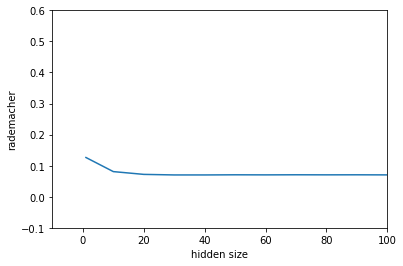

program: avrora-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
max: -1.5183052964930157, min: -3.8647771183458586, Range: 0.005521110169065508
Alpha for 0.005521110169065508 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.16958671515166918


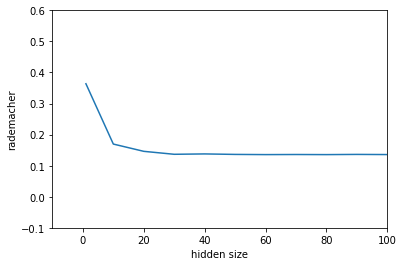

program: jython-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
max: -1.380277542266378, min: -2.8985828387593937, Range: 0.004140832626799131
Alpha for 0.004140832626799131 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.1143523216071393


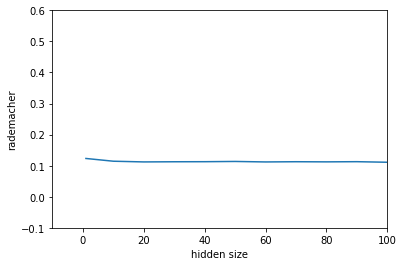

program: jython-small-J9-d-l64-p4096-w100000i.analyzed-1
max: -1.380277542266378, min: -6.90138771133189, Range: 0.001380277542266377
Alpha for 0.001380277542266377 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 20, y: 0.1745227278350785


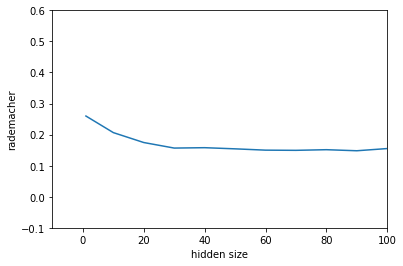

program: sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
max: -1.6563330507196534, min: -3.7957632412325397, Range: 0.001380277542266377
Alpha for 0.001380277542266377 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.08944953950327263


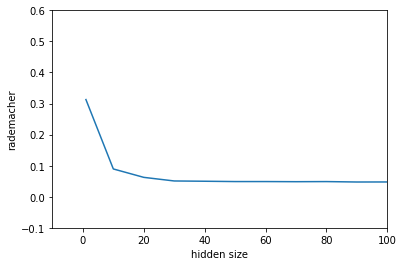

program: xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
max: -1.380277542266378, min: -4.3478742581390915, Range: 0.005521110169065526
Alpha for 0.005521110169065526 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.02737824781996649


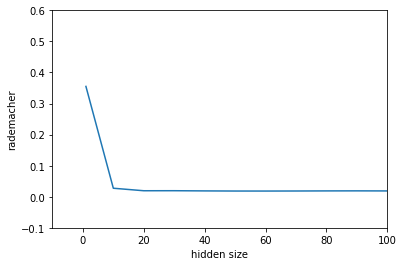

program: xalan-small-J9-d-l64-p4096-w100000i.analyzed-1
max: -1.3112636651530591, min: -3.450693855665945, Range: 0.004140832626799131
Alpha for 0.004140832626799131 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.1772846159902012


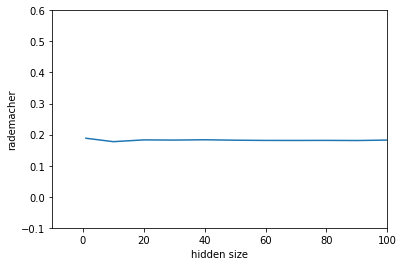

program: xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
max: -1.380277542266378, min: -4.140832626799134, Range: 0.008281665253598263
Alpha for 0.008281665253598263 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.10680547135139022


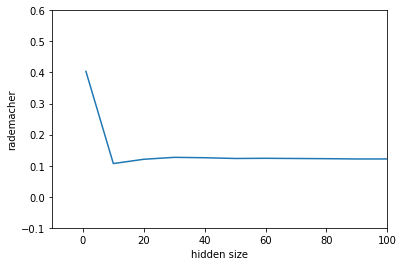

program: pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
max: -1.380277542266378, min: -4.3478742581390915, Range: 0.005521110169065526
Alpha for 0.005521110169065526 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.04628700889599632


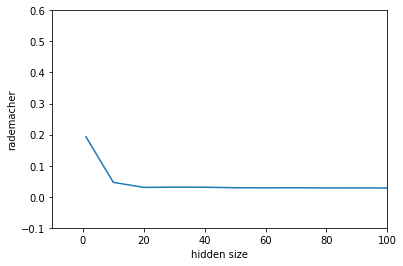

program: pmd-small-J9-d-l64-p4096-w100000i.analyzed-1
max: -1.2422497880397403, min: -6.90138771133189, Range: 0.004140832626799131
Alpha for 0.004140832626799131 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.09852721869085852


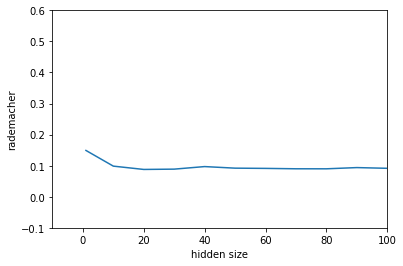

program: pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
max: -1.1732359109264214, min: -6.90138771133189, Range: 0.008281665253598263
Alpha for 0.008281665253598263 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.13334168054521858


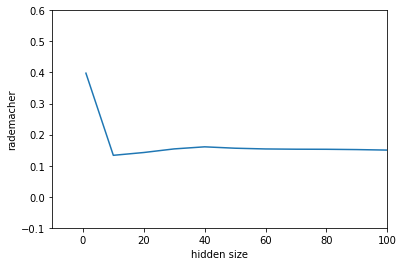

program: sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
max: -1.380277542266378, min: -3.657735487005902, Range: 0.005521110169065508
Alpha for 0.005521110169065508 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.04980715559555814


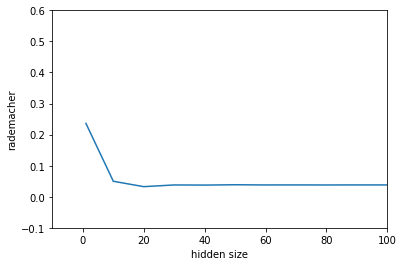

program: sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1
max: -1.380277542266378, min: -6.90138771133189, Range: 0.005521110169065508
Alpha for 0.005521110169065508 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.013195740333791828


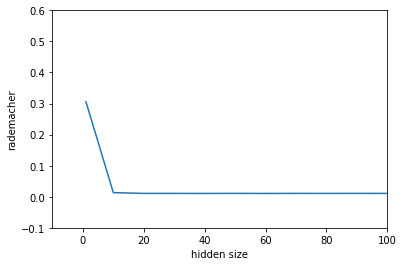

program: luindex-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
max: -1.6563330507196534, min: -6.90138771133189, Range: 0.006901387711331886
Alpha for 0.006901387711331886 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.39488762493448154


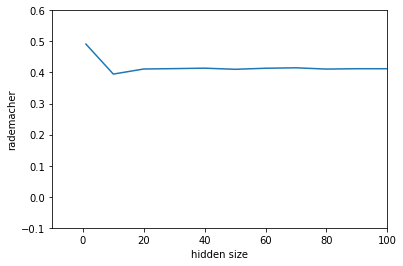

program: lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
max: -1.380277542266378, min: -3.9337909954591774, Range: 0.004140832626799131
Alpha for 0.004140832626799131 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.03287081799242108


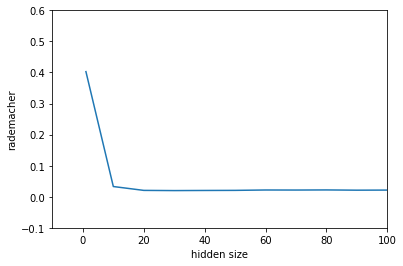

program: lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1
max: -1.2422497880397403, min: -2.760555084532756, Range: 0.004140832626799131
Alpha for 0.004140832626799131 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.04103845968185931


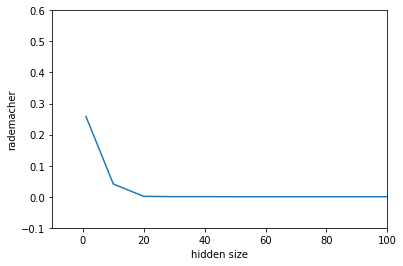

program: lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
max: -1.6563330507196534, min: -4.140832626799134, Range: 0.006901387711331886
Alpha for 0.006901387711331886 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.2931662173987727


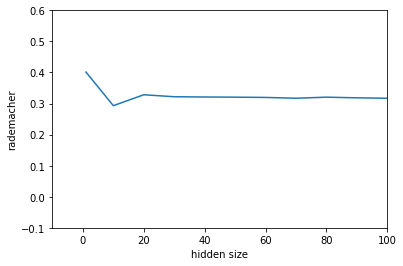

program: jython-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1
max: -1.8633746820596109, min: -6.90138771133189, Range: 0.012422497880397404
Alpha for 0.012422497880397404 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.2688945308270726


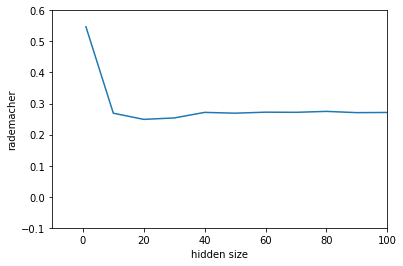

program: luindex-small-HotSpot-d-l64-p4096-w100000i.analyzed-1
max: -1.4492914193796969, min: -4.3478742581390915, Range: 0.004140832626799131
Alpha for 0.004140832626799131 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.0462724404673737


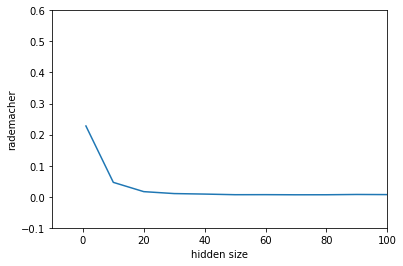

program: luindex-small-J9-d-l64-p4096-w100000i.analyzed-1
max: -1.4492914193796969, min: -3.1056244700993507, Range: 0.004140832626799131
Alpha for 0.004140832626799131 found at 0 and value: 0.03
Computations complete
Plotting...
Knee point x: 10, y: 0.04144373900127486


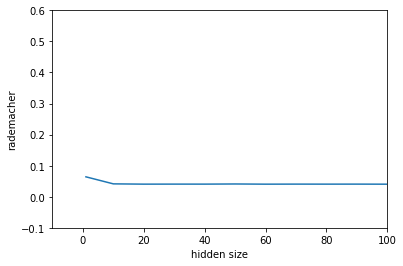

In [17]:
## Analysis of virtual machine trends in programs
programs=file_list
print(programs)
result_dict = {}

for program in programs:
    print("program: {}".format(program))
    trace = pd.read_pickle(
                '../data/{}.pkl'.format(program)
            ).to_numpy()[10000:10000+15000]
    
    trace_conv = []
    
    for idx in range(trace.shape[0]):
        trace_conv.append(utils.common.bin_to_val(int(np.argmax(trace[idx, :].flatten()))))
    
    diff = np.abs(np.max(trace_conv) - np.min(trace_conv))/50
    
    q75, q25 = np.percentile(trace_conv, [75 ,25])
    diff = (q75 - q25)/50
    
    diff_arr = np.abs(alpha_list - diff**2)
    min_alpha = np.argmin(diff_arr)
    
    print("max: {}, min: {}, Range: {}".format(np.max(trace_conv), np.min(trace_conv), diff))
    print("Alpha for {} found at {} and value: {}".format(diff, min_alpha, alpha_list[min_alpha]))
    
    with open(os.path.join(directory, "{}.response.pkl".format(program)), 'rb') as f:
        response_dict = pkl.load(f)
        
    hidden_sizes =list(response_dict.keys())
#     hidden_sizes = hidden_sizes[:10]
    rademacher_data = []
    
    for hidden_size in hidden_sizes:
        response_array = response_dict[hidden_size]
        alpha_idx = min_alpha
        loss_array = response_array[alpha_idx, :, :]
        rademacher_val = get_rademacher(loss_array)
    
        rademacher_data.append(rademacher_val)
        
    print("Computations complete")
    print("Plotting...")
    
    fig = plt.figure()
    plt.plot(hidden_sizes, rademacher_data)
    
    kneedle = KneeLocator(list(hidden_sizes), rademacher_data, S=1.0, curve='convex', direction='decreasing')
    print("Knee point x: {}, y: {}".format(kneedle.knee, kneedle.knee_y))
    
    result_dict['-'.join(program.split('-')[:3])] = kneedle.knee_y
    
    plt.xlabel("hidden size")
    plt.ylabel("rademacher")
    plt.ylim((-0.1, 0.6))
    plt.xlim((-10, 100))
    plt.show()

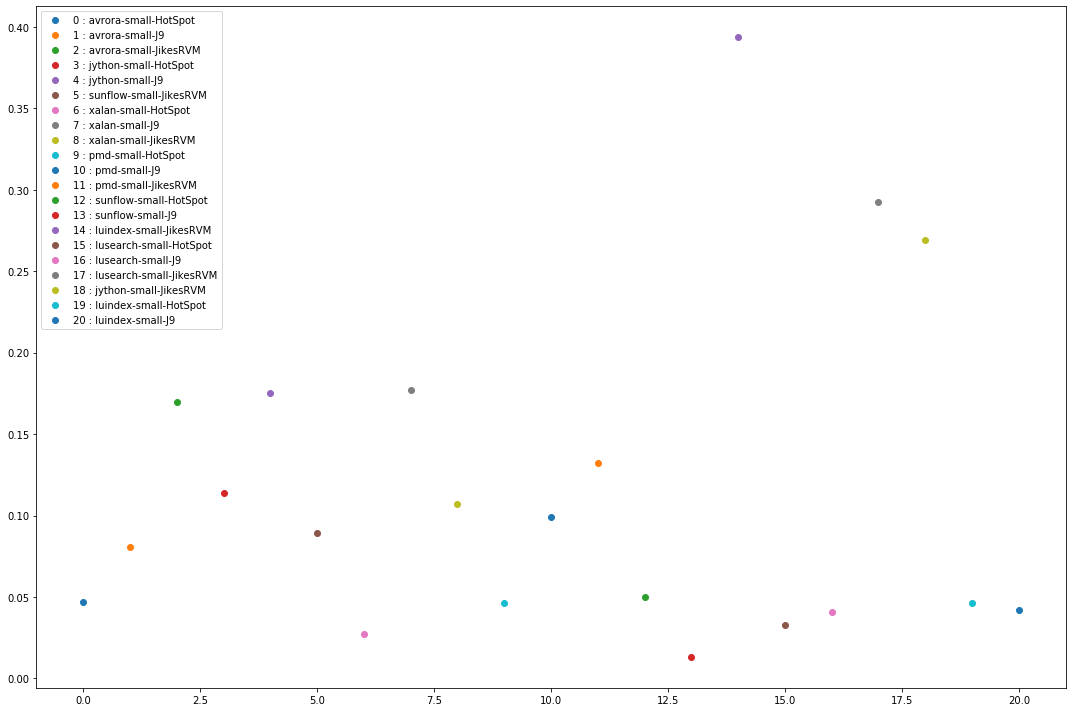

In [15]:
data = []
legend = []
plt.figure(figsize=(15,10))
for idx, key in enumerate(result_dict.keys()):
    plt.plot(idx, result_dict[key], 'o', label=str(idx)+" : "+'-'.join(key.split('-')[:3]))

plt.tight_layout()
plt.legend()
# plt.ylim(2e4,6e4)
plt.show()

In [16]:
## Analysis of virtual machine trends in programs

keys = result_dict.keys()
programs = [ key.split('-')[0] for key in keys ]
programs = np.unique(programs)

for program in programs:
    print("Program: {}".format(program))
    sub_dict = { key: val for key, val in result_dict.items() if key.split('-')[0] == program }
    
#     print(sub_dict)
    
    tuple_jvms = [ (key.split('-')[2], val) for key, val in sub_dict.items() ]
    
#     print(tuple_jvms)
    
    tuple_jvms = sorted(tuple_jvms, key=lambda tuple_jvm: tuple_jvm[1])
    
    print(tuple_jvms)

Program: avrora
[('HotSpot', 0.04718167136527532), ('J9', 0.08095179101770315), ('JikesRVM', 0.16954395440355388)]
Program: jython
[('HotSpot', 0.11388328932543233), ('J9', 0.1751889707874385), ('JikesRVM', 0.26901910575095883)]
Program: luindex
[('J9', 0.04169633376732457), ('HotSpot', 0.046191194681466576), ('JikesRVM', 0.3935275073253059)]
Program: lusearch
[('HotSpot', 0.03290051151624613), ('J9', 0.04091046311394385), ('JikesRVM', 0.29269303835489563)]
Program: pmd
[('HotSpot', 0.04602817225256293), ('J9', 0.09913284877132925), ('JikesRVM', 0.13203764577237723)]
Program: sunflow
[('J9', 0.013253601267428382), ('HotSpot', 0.05004461381557884), ('JikesRVM', 0.08941290332585655)]
Program: xalan
[('HotSpot', 0.02751719861159433), ('JikesRVM', 0.1071272948871262), ('J9', 0.1773074729685003)]
